In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg

from src.simpleEDMD import *
import src.dictionary_strategy as d_strategy

%load_ext autoreload
%autoreload 2
%matplotlib inline

np.set_printoptions(suppress=True,precision=4)

# Analytical Solution

In [2]:
def analytical_koopman_eigenfunction(x,y,i,j):
    return np.power((x-y)/np.sqrt(2),i)*np.power(y,j)

def analytical_koopman_eigenvalue(i,j):
    return np.power(0.9,i)*np.power(0.8,j)


In [3]:
x1 = np.arange(-5, 5.1, 0.1)
x2 = np.arange(-5, 5.1, 0.1)
xx1, xx2 = np.meshgrid(x1, x2)

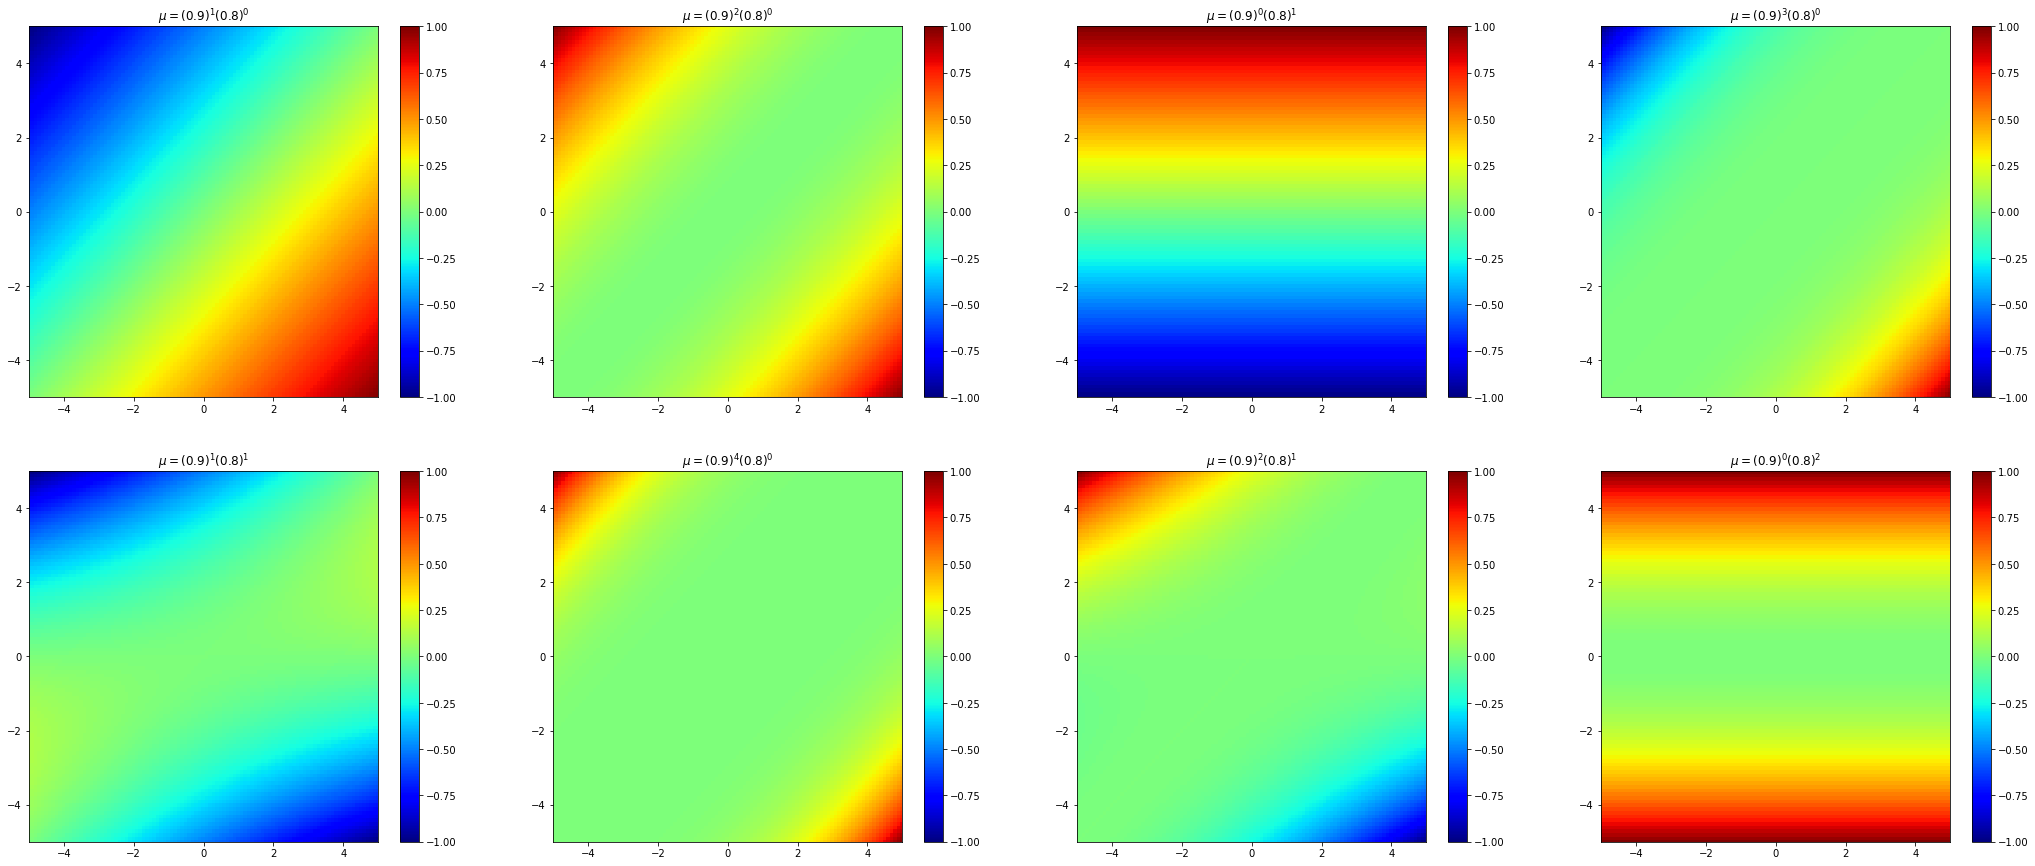

In [4]:
fig, axs = plt.subplots(2, 4,figsize=(36,15))
ij = [[1,0],[2,0],[0,1],[3,0],[1,1],[4,0],[2,1],[0,2]] #normalized to [-1,1]
for index, power in enumerate(ij):
    
    i = power[0]
    j = power[1]

    z = analytical_koopman_eigenfunction(xx1,xx2,i,j)
   
    temp = z.flatten()
    inf_norm = np.linalg.norm(temp, np.inf)
    normalized_z = np.array( [v/inf_norm for v in z])

    if index < 4:
        ax = axs[0,index]
    else:
        ax = axs[1,index-4]
    c = ax.pcolor(x1, x2, normalized_z, cmap='jet', vmin=-1, vmax=1, shading='auto')
    ax.set_title('$\mu = (0.9)^{}(0.8)^{}$'.format(i,j))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    fig.colorbar(c, ax=ax)

# Data generation
for example4.1.1

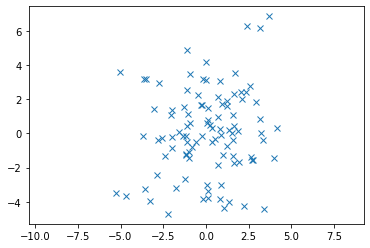

In [5]:
#generate X as 100 normally distributed initial conditions 2x100
mean = [0, 0]
cov = [[5, 0], [0, 5]]
x1, x2 = np.random.multivariate_normal(mean, cov, 100).T
plt.plot(x1, x2, 'x')
plt.axis('equal')
plt.show()

X = []
for i in range(0,100):
    X.append([x1[i],x2[i]])
X = np.array(X)

In [6]:
#generate true Y by multiplying J
J = np.array([[0.9, -0.1],[0, 0.8]])
Y = []
for i in range(0,100):
    xi = X[i]
    yi = J@xi
    Y.append(yi)

Y = np.array(Y)

# EDMD for linear example

In [7]:
herimite_strategy = d_strategy.Herimite_strategy()
linearEDMD = simpleEDMD(X,Y, herimite_strategy)

In [8]:
linearEDMD.compute_koopman_operator()

In [9]:
K = linearEDMD.koopman_matrix

## Koopman Eigenvalues

In [10]:
Mu = linearEDMD.koopman_eigenvalues
Mu # correctly responding to eigenvalues in Fig.3

array([1.    +0.j    , 0.9   +0.j    , 0.81  +0.j    , 0.8   +0.j    ,
       0.729 +0.j    , 0.72  +0.j    , 0.6561+0.j    , 0.648 +0.j    ,
       0.64  +0.j    , 0.5832+0.j    , 0.576 +0.j    , 0.5402+0.0696j,
       0.5402-0.0696j, 0.5184+0.j    , 0.512 +0.j    , 0.4608+0.j    ,
       0.4441+0.0774j, 0.4441-0.0774j, 0.4096+0.j    , 0.3851+0.j    ,
       0.2819+0.118j , 0.2819-0.118j , 0.2529+0.0579j, 0.2529-0.0579j,
       0.1218+0.j    ])

## Koopman Eigenfunctions

In [11]:
Xi = linearEDMD.right_eigenvectors
Xi.shape

(25, 25)

In [12]:
x1 = np.arange(-5, 5.1, 0.1)
x2 = np.arange(-5, 5.1, 0.1)
xx1, xx2 = np.meshgrid(x1, x2)
eX = np.array([xx1.reshape(-1), xx2.reshape(-1)])
eX = eX.T

In [13]:
Psi = linearEDMD.dictionary_Hermite_poly(eX)
eZ = Psi@Xi.real
print(eZ.shape)

(10201, 25)


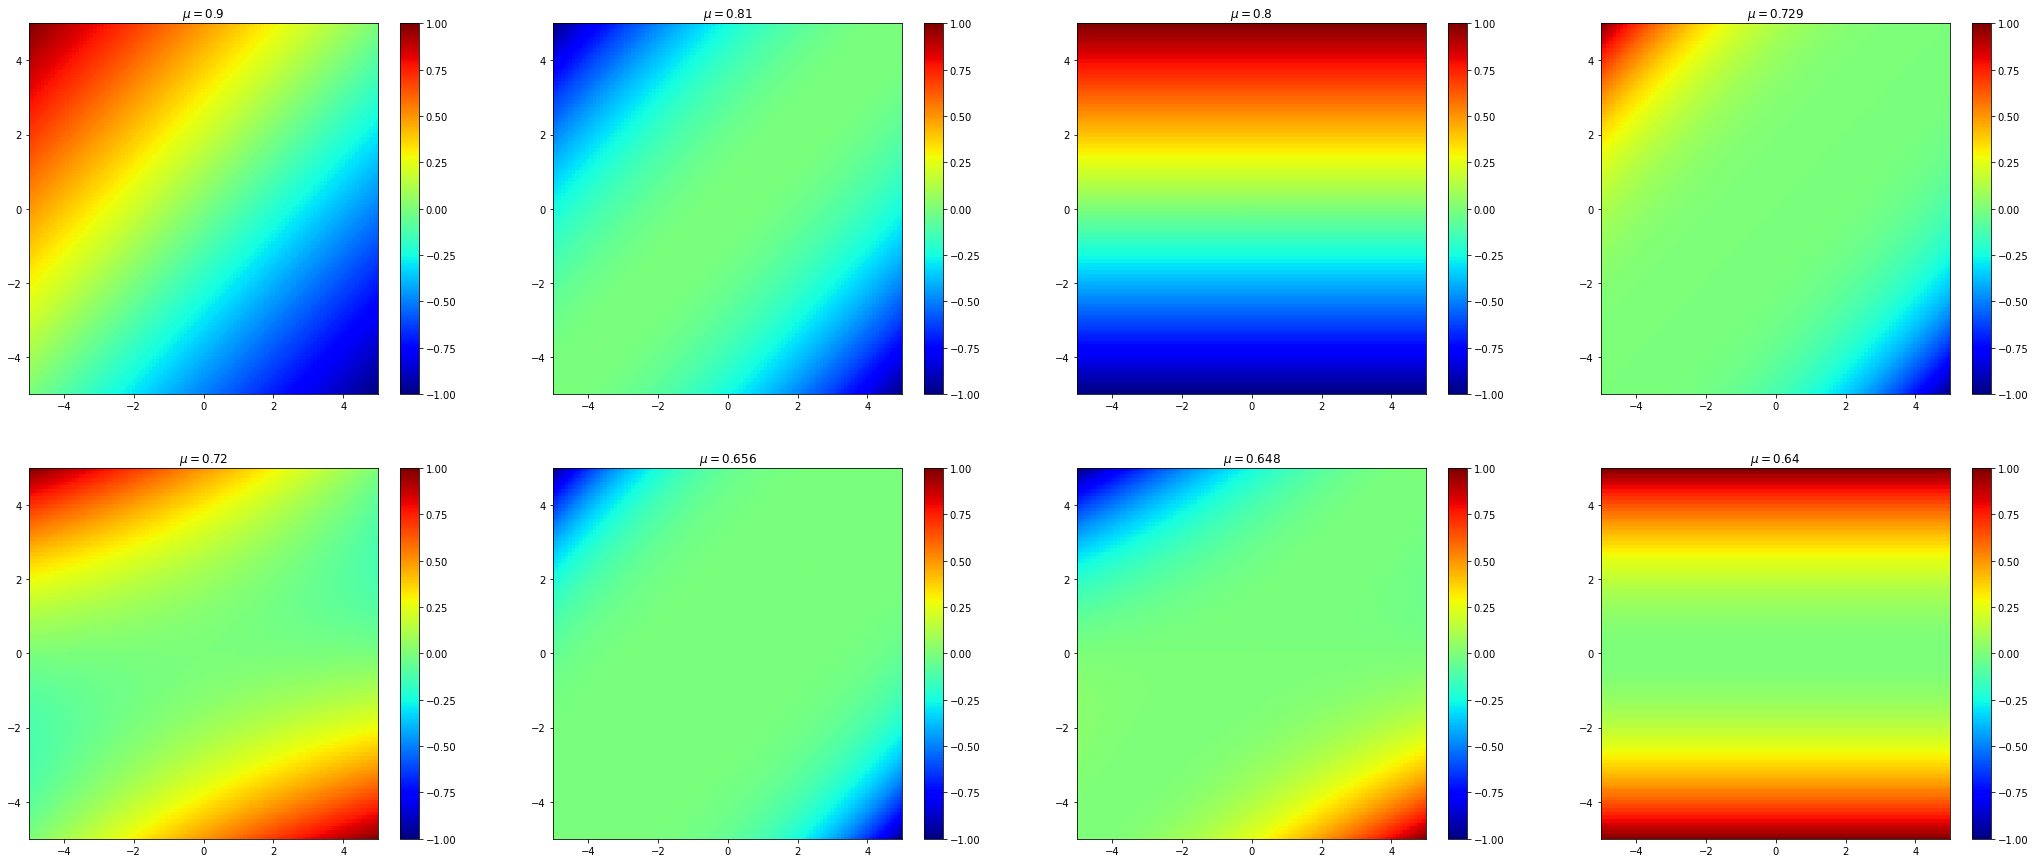

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(36,15))

for index in range(1,9):
    temp = eZ[:, index].flatten()
    inf_norm = np.linalg.norm(temp, np.inf)
    normalized_ez = np.array( [v/inf_norm for v in temp])

    if index <= 4:
        ax = axs[0,index -1]
    else:
        ax = axs[1,index-5]
    normalized_ez = normalized_ez.reshape(xx1.shape[0],xx1.shape[1])

    c = ax.pcolor(x1, x2, normalized_ez, cmap='jet', vmin=-1, vmax=1, shading='auto')
    
    ax.set_title('$\mu = {}$'.format(np.round(Mu[index].real,3)))
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    fig.colorbar(c, ax=ax)

## Koopman Modes

In [15]:
Wstar = linearEDMD.left_eigenvectors
w = linearEDMD.levecs

print('Unscaled 2nd left eigenvector: ' , w[:,1])
print('Scaled 2nd left eigenvector: ' , Wstar[:,1])
print('w_2@xi_2 = 1 : ', Wstar[:,24]@Xi[:,24])

Unscaled 2nd left eigenvector:  [-0.    +0.j -0.062 +0.j  0.    +0.j  0.0232+0.j  0.    +0.j  0.    +0.j
 -0.    +0.j  0.    +0.j -0.    +0.j  0.    +0.j -0.    +0.j -0.    +0.j
 -0.    -0.j -0.    +0.j  0.    +0.j -0.    +0.j -0.    -0.j -0.    +0.j
  0.    +0.j -0.    +0.j -0.    +0.j -0.    -0.j  0.    -0.j  0.    +0.j
 -0.    +0.j]
Scaled 2nd left eigenvector:  [ 0.    -0.j -1.4142+0.j -0.    +0.j  2.1213-0.j  0.    -0.j  0.    +0.j
 -0.    +0.j -0.    -0.j  0.    -0.j -0.5077-0.j  0.    +0.j  0.7071-0.j
  0.    -0.j -0.4792+0.j  0.9964+0.j -0.    -0.j  0.    -0.j -1.0779-0.j
 -1.601 +0.j -8.8689+0.j  0.    -0.j  2.2378+0.j  3.5202-0.j 18.0162-0.j
  9.3275-0.j]
w_2@xi_2 = 1 :  (1.0000000000000007+7.374523504338222e-18j)
